# Preprocessing of Dataset
### 1. Motivation and Goal
This notebook is for preprocessing and cleaning the dataset. We are going to read the data a structure it in a coherent way. With cleaning we mean that all the columns in the dataset needs the correct type, we want numbers to be numbers (and not strings) and dates to be dates etc. We will also find a way to deal with missing values and drop or transform columns which are not needed / in need of a transformation. 

The output of this notebook is a csv-file is more suitable to do exploratory data analysis on compared to the raw data. 

### 2. Imports

In [28]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas_ods_reader import read_ods

### 3. Read Data

In [29]:
class ReadData:
    def __init__(self, file_path):
        """
        The .ods-file consists of sheets which all are read individualy.
        This class reads all the sheets and concatenates them into a single
        pandas DataFrame.
        """
        sheet = 0
        self.df = read_ods(file_path, sheet)
        while True:
            try:
                new_sheet = read_ods(file_path, sheet)
                new_sheet = new_sheet.drop(0)
                new_sheet = new_sheet.drop(1)
                self.df = pd.concat([self.df, new_sheet])
                sheet += 1
            except IndexError as e:
                break
        self.descriptions = self.df.iloc[0].to_dict()
        self.df = self.df.drop(0) 
        self.df = self.df.drop(1)

    def get_data(self):
        """
        Retrieve the DataFrame and a dictionary with descriptions
        of the columns in the DataFrame
        """
        return self.df, self.descriptions

In [30]:
# Read the data
file_path = "./data/glofdatabase_V3.ods"
rd = ReadData(file_path)
original_df, COLUMN_DESCRIPTIONS = rd.get_data()

In [31]:
# View head of df
original_df.head()

,ID,Major_RGI_Region,Mountain_range_Region,Country,Glacier,RGI_Glacier_Id,RGI_Glacier_Area,Lake,Lake_type,Longitude,...,Lake_area_after,Perimeter_after,Image_date_after,Satellite_after,Scenename_after,Certainty_level_after,Lake_area_comments,unnamed.1,unnamed.3,unnamed.4
2,1.0,None,None,Greenland,None,RGI60-05.00334,238.201,Iluliallup Tasersua,ice,-51.815633,...,None,None,None,None,None,None,None,NaN,NaN,NaN
3,2.0,None,None,Greenland,Sermilik Bræ,None,None,Imaersartoq,ice,-48.454648,...,None,None,None,None,None,None,None,NaN,NaN,NaN
4,3.0,None,None,Greenland,Sermiligårssuk Bræ,None,None,North Midternæs temporary lake,ice,-47.965525,...,None,None,None,None,None,None,None,NaN,NaN,NaN
5,4.0,None,None,Greenland,Sermilik Bræ,None,None,Imaersartoq,ice,-48.454648,...,None,None,None,None,None,None,None,NaN,NaN,NaN
6,5.0,None,None,Greenland,Sermiligårssuk Bræ,None,None,North Midternæs temporary lake,ice,-47.965525,...,None,None,None,None,None,None,None,NaN,NaN,NaN


In [100]:
# View descriptions of some columns
print(COLUMN_DESCRIPTIONS['Country'])
print(COLUMN_DESCRIPTIONS['Lake_area_before'])

Source location of the GLOF
Lake area before outburst


### 4. Preprocessing and Cleaning

In [33]:
# print number of columns and rows
print("Number of rows in dataset:", len(original_df))
print("Number of columns in dataset", len(original_df.columns))

Number of rows in dataset: 3457
Number of columns in dataset 60


In [34]:
# See the types of the columns
original_df.dtypes

ID                         object
Major_RGI_Region           object
Mountain_range_Region      object
Country                    object
Glacier                    object
RGI_Glacier_Id             object
RGI_Glacier_Area           object
Lake                       object
Lake_type                  object
Longitude                  object
Latitude                   object
River                      object
Date                       object
Date_Min                   object
Date_Max                   object
Mechanism                  object
Mean_Lake_Volume_VL        object
Min_VL                     object
Max_VL                     object
VL_calculation             object
Mean_Flood_Volume_V0       object
Min_V0                     object
Max_V0                     object
V0_calculation             object
Peak_discharge_Qp          object
Min_Qp                     object
Max_Qp                     object
Qp_calculation             object
Impact_and_destruction     object
reported_impac

**Comment:** Every column is a string apparently.

In [35]:
# Find numerical columns and date columns
original_numerical_columns = ['ID', 'RGI_Glacier_Area', 'Longitude', 'Latitude', 'Mean_Lake_Volume_VL', 'Min_VL', 'Max_VL', 'Mean_Flood_Volume_V0', 'Min_V0',
'Max_V0', 'Peak_discharge_Qp', 'Min_Qp', 'Max_Qp', 'D_buildings', 'D_bridges', 'D_roads_paths', 'reported_fatalities', 'First_reference_found',
'Lake_area_before', 'Perimeter_before', 'Certainty_level_before', 'Lake_area_after', 'Perimeter_after', 'Certainty_level_after']
original_date_columns = ['Date', 'Date_Min', 'Date_Max', 'Image_date_before', 'Image_date_after']

In [36]:
import datetime as dt
import re

def convert_to_float(x):
    try:
        x = float(x)
    except Exception as e:
        x = np.NaN
    return x

def convert_to_datetime(x):
    """
    Converts string or float values into dt.datetime format
    """
    if isinstance(x, str):
        try:
            # Some dates are on the format YYYY-MM-DD
            # these are converted here
            x = x.split('-')
            if len(x) == 1:
                x = dt.datetime(int(x[0]), 1, 1)
                return x
            elif len(x) == 2:
                x = dt.datetime(int(x[0]), int(x[1]), 1)
                return x
            elif len(x) == 3:
                x = dt.datetime(int(x[0]), int(x[1]), int(x[2]))
                return x
        except Exception as e:
            # Many dates have a useless type such as 'annually' or 'Late 18th Century ' => nullify these
            # Others are on the form '1940s' or similar => keep these
            if x is None:
                return None
            x = re.sub('/D', '', x[0])
            if len(x) < 4:
                return None
            elif len(x) == 4:
                x = dt.datetime(int(x), 1, 1)
            else:
                return None
            return x
    elif isinstance(x, float) or isinstance(x, int):
        x = dt.datetime(int(round(x)), 1, 1)

def convert_columns_to_numerical(columns, df: pd.DataFrame):
    """
    Converts numerical columns (specified by the columns-parameter) to numbers 
    """
    for col in columns:
        df[col] = df[col].apply(convert_to_float)

    return df

def convert_columns_to_date(columns, df: pd.DataFrame):
    """
    Converts date-columns (specified by the columns-parameter) to dates 
    """
    for col in columns:
        df[col] = df[col].apply(convert_to_datetime)

    return df

In [37]:
df = original_df.copy()
df = convert_columns_to_numerical(original_numerical_columns, df)
df = convert_columns_to_date(original_date_columns, df)

In [38]:
df.dtypes

ID                               float64
Major_RGI_Region                  object
Mountain_range_Region             object
Country                           object
Glacier                           object
RGI_Glacier_Id                    object
RGI_Glacier_Area                 float64
Lake                              object
Lake_type                         object
Longitude                        float64
Latitude                         float64
River                             object
Date                              object
Date_Min                          object
Date_Max                          object
Mechanism                         object
Mean_Lake_Volume_VL              float64
Min_VL                           float64
Max_VL                           float64
VL_calculation                    object
Mean_Flood_Volume_V0             float64
Min_V0                           float64
Max_V0                           float64
V0_calculation                    object
Peak_discharge_Q

**Comment:** Now, the numerical columns have float-types and date-columns have dt.datetime format.

In [90]:
def get_year(x):
    if isinstance(x, dt.datetime):
        return x.year
    else:
        return pd.NA


df['Year'] = df['Date'].apply(get_year)

### 5. Analyze Missing Values

In [39]:
df.head(1)

,ID,Major_RGI_Region,Mountain_range_Region,Country,Glacier,RGI_Glacier_Id,RGI_Glacier_Area,Lake,Lake_type,Longitude,...,Lake_area_after,Perimeter_after,Image_date_after,Satellite_after,Scenename_after,Certainty_level_after,Lake_area_comments,unnamed.1,unnamed.3,unnamed.4
2,1.0,None,None,Greenland,None,RGI60-05.00334,238.201,Iluliallup Tasersua,ice,-51.815633,...,NaN,NaN,NaT,None,None,NaN,None,None,NaN,NaN


Text(0.5, 1.0, 'Percentage of Missing Values by Column')

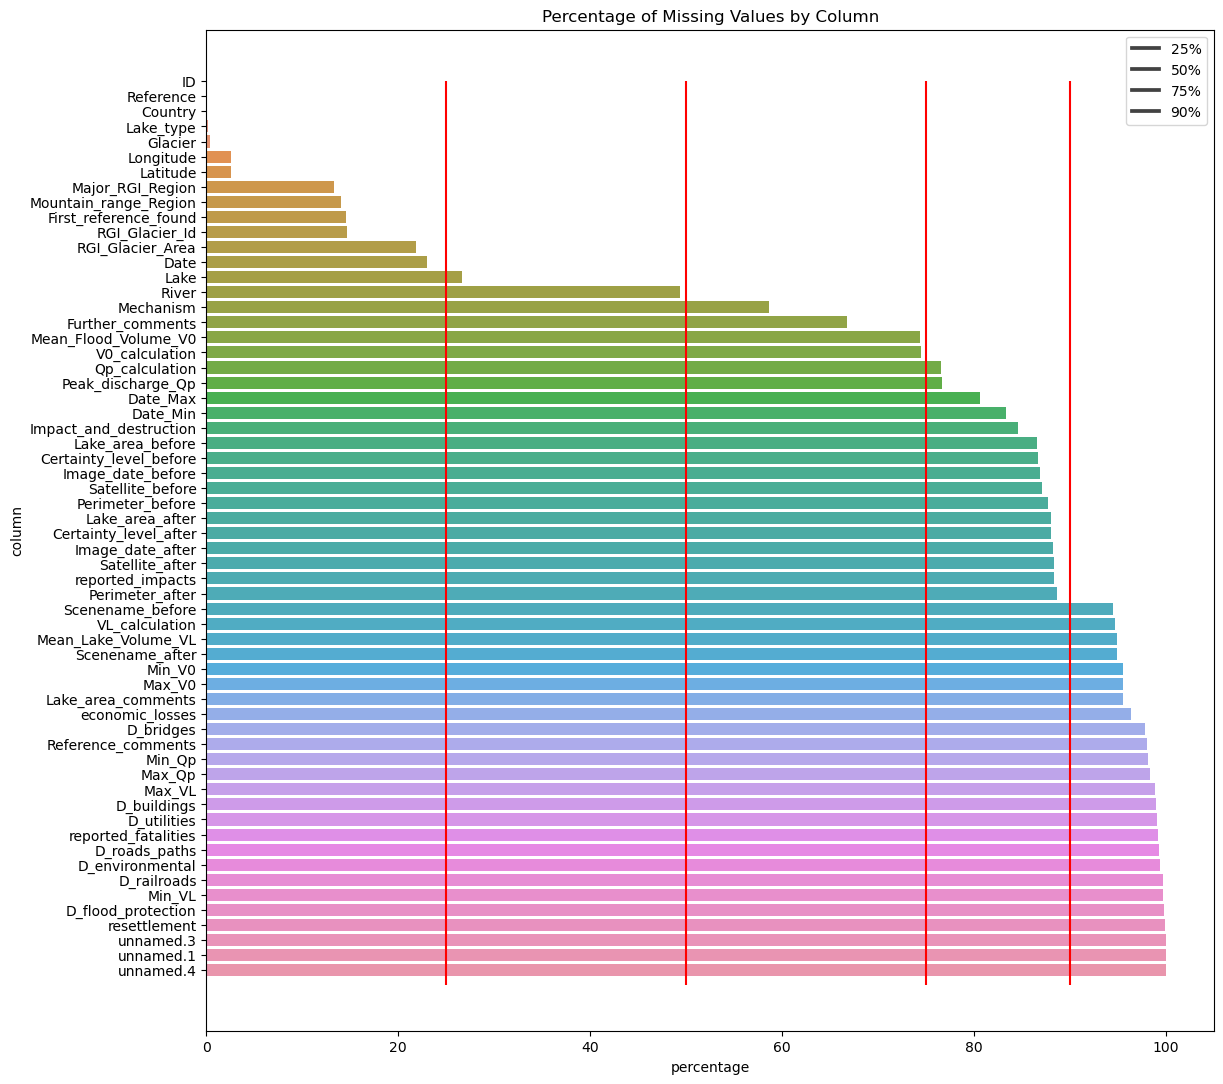

In [40]:
# Plot the percentage of missing values by column
missing_values_by_column = {'column': [], 'percentage': []}

for col in df.columns:
    percentage = len(df[df[col].isna()]) / len(df)
    missing_values_by_column['column'].append(col)
    missing_values_by_column['percentage'].append(percentage)

missing_values_df = pd.DataFrame(missing_values_by_column)
missing_values_df['percentage'] = missing_values_df['percentage'] * 100

fig = plt.figure(figsize=(13, 13))
g = sns.barplot(data=missing_values_df.sort_values(by='percentage'), x='percentage', y='column',)
plt.vlines(x=25, ymin=0, ymax=60, colors='red')
plt.vlines(x=50, ymin=0, ymax=60, colors='red')
plt.vlines(x=75, ymin=0, ymax=60, colors='red')
plt.vlines(x=90, ymin=0, ymax=60, colors='red')
plt.legend(['25%', '50%', '75%', '90%'])
plt.title('Percentage of Missing Values by Column')

In [41]:
missing_values_df.sort_values(by='percentage', ascending=False)

,column,percentage
59,unnamed.4,99.971073
58,unnamed.3,99.971073
57,unnamed.1,99.971073
38,resettlement,99.826439
36,D_flood_protection,99.739659
17,Min_VL,99.710732
34,D_railroads,99.681805
37,D_environmental,99.363610
33,D_roads_paths,99.276830
39,reported_fatalities,99.161122


In [42]:
# Drop columns with a too large share of missing values
missing_value_threshold = 90
cols_to_delete = missing_values_df[missing_values_df['percentage'] >= missing_value_threshold]['column'].values.tolist()
df = df.drop(columns=cols_to_delete)

Text(0.5, 1.0, 'Percentage of Missing Values by Column')

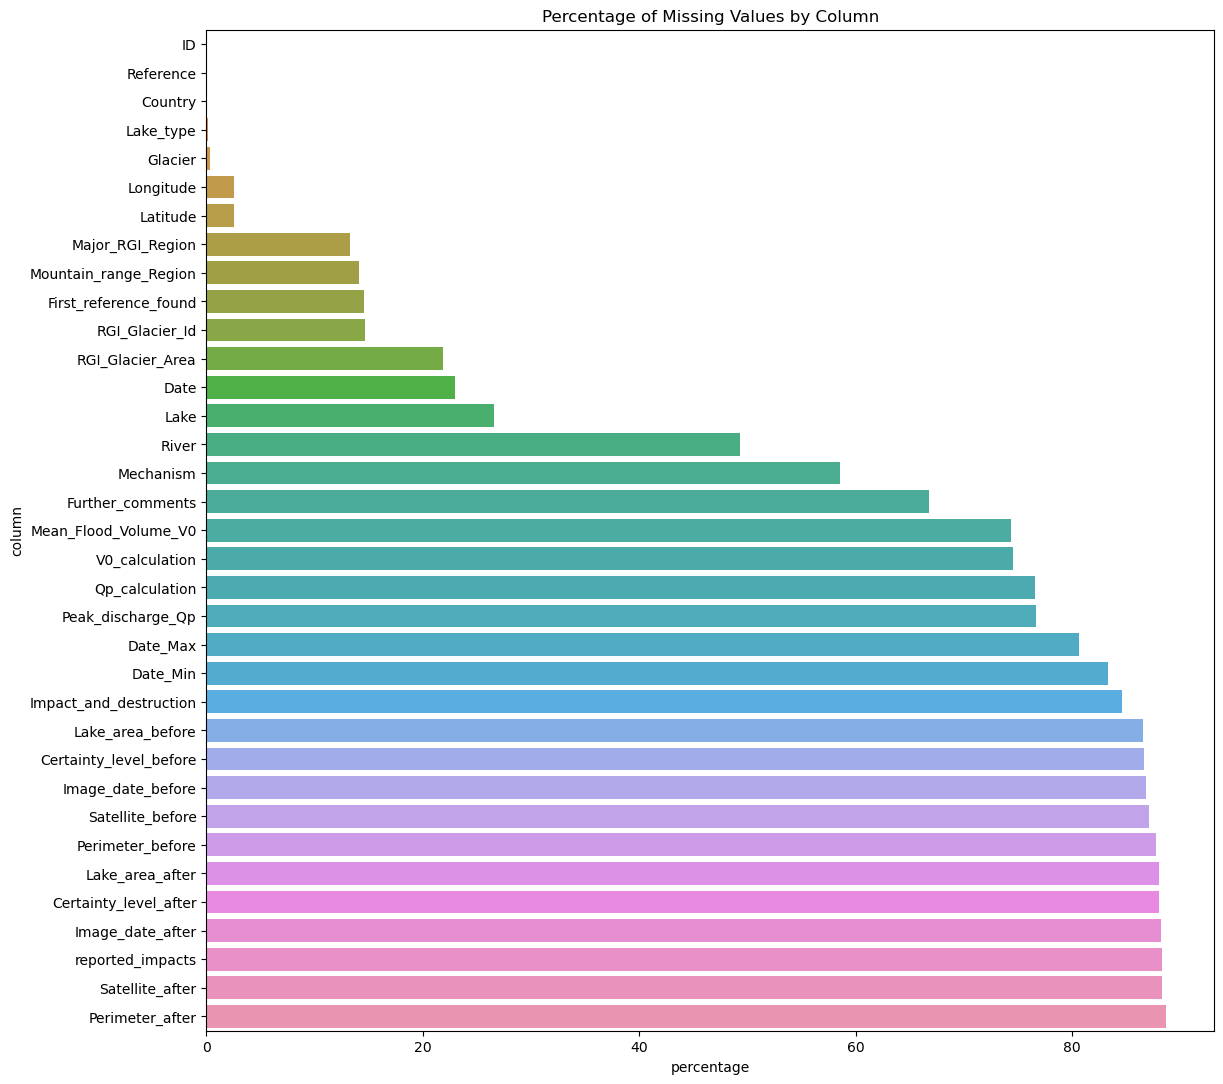

In [43]:
missing_values_by_column = {'column': [], 'percentage': []}

for col in df.columns:
    percentage = len(df[df[col].isna()]) / len(df)
    missing_values_by_column['column'].append(col)
    missing_values_by_column['percentage'].append(percentage)

missing_values_df = pd.DataFrame(missing_values_by_column)
missing_values_df['percentage'] = missing_values_df['percentage'] * 100

fig = plt.figure(figsize=(13, 13))
sns.barplot(data=missing_values_df.sort_values(by='percentage'), x='percentage', y='column')
plt.title('Percentage of Missing Values by Column')

In [44]:
# Drop other non-necessary columns
df = df.drop(columns=['Reference'])

#### 5.1 Fill missing values for numerical columns

In [45]:
numerical_cols_with_missing_values = set(df.columns).intersection(set(original_numerical_columns))
numerical_cols_with_missing_values.remove('ID')

In [46]:
numerical_cols_with_missing_values

{'Certainty_level_after',
 'Certainty_level_before',
 'First_reference_found',
 'Lake_area_after',
 'Lake_area_before',
 'Latitude',
 'Longitude',
 'Mean_Flood_Volume_V0',
 'Peak_discharge_Qp',
 'Perimeter_after',
 'Perimeter_before',
 'RGI_Glacier_Area'}

In [47]:
print(df.Certainty_level_before.unique())
print(df.Certainty_level_after.unique())

[nan  2.  1.]
[nan  1.  2.]


In [48]:
# We set Certainity_level_before and Certainity_level_after missing values to 0
df['Certainty_level_after'] = df['Certainty_level_after'].fillna(0)
df['Certainty_level_before'] = df['Certainty_level_before'].fillna(0)

#### 5.2 Fill Missing Values for Categorical Variables

In [49]:
categotical_columns = set(df.columns).difference(set(numerical_cols_with_missing_values))

In [50]:
categotical_columns

{'Country',
 'Date',
 'Date_Max',
 'Date_Min',
 'Further_comments',
 'Glacier',
 'ID',
 'Image_date_after',
 'Image_date_before',
 'Impact_and_destruction',
 'Lake',
 'Lake_type',
 'Major_RGI_Region',
 'Mechanism',
 'Mountain_range_Region',
 'Qp_calculation',
 'RGI_Glacier_Id',
 'River',
 'Satellite_after',
 'Satellite_before',
 'V0_calculation',
 'reported_impacts'}

In [85]:
df['Further_comments'] = df['Further_comments'].fillna('unknown')
df['Lake'] = df['Lake'].fillna('unknown')
df['Lake_type'] = df['Lake_type'].fillna('unknown')
df[df['Lake_type'] == ' ']['Lake_type'] = 'unknown'
df['Major_RGI_Region'] = df['Major_RGI_Region'].fillna('unknown')
df['Mechanism'] = df['Mechanism'].fillna('unknown')
df['Mountain_range_Region'] = df['Mountain_range_Region'].fillna('unknown')
df['River'] = df['River'].fillna('unknown')
df['Satellite_after'] = df['Satellite_after'].fillna('unknown')
df['Satellite_before'] = df['Satellite_before'].fillna('unknown')
df['reported_impacts'] = df['reported_impacts'].fillna('unknown')

df = df.drop(columns=['Qp_calculation', 'RGI_Glacier_Id', 'V0_calculation'])

/var/folders/ft/35gzrsh14bd62d709j269hgr0000gn/T/ipykernel_92614/2647234929.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[df['Lake_type'] == ' ']['Lake_type'] = 'unknown'


In [86]:
df.head(5)

,ID,Major_RGI_Region,Mountain_range_Region,Country,Glacier,RGI_Glacier_Area,Lake,Lake_type,Longitude,Latitude,...,Lake_area_before,Perimeter_before,Image_date_before,Satellite_before,Certainty_level_before,Lake_area_after,Perimeter_after,Image_date_after,Satellite_after,Certainty_level_after
2,1.0,unknown,unknown,Greenland,None,238.201,Iluliallup Tasersua,ice,-51.815633,65.774120,...,NaN,NaN,NaT,unknown,0.0,NaN,NaN,NaT,unknown,0.0
3,2.0,unknown,unknown,Greenland,Sermilik Bræ,NaN,Imaersartoq,ice,-48.454648,61.954559,...,NaN,NaN,NaT,unknown,0.0,NaN,NaN,NaT,unknown,0.0
4,3.0,unknown,unknown,Greenland,Sermiligårssuk Bræ,NaN,North Midternæs temporary lake,ice,-47.965525,61.676943,...,NaN,NaN,NaT,unknown,0.0,NaN,NaN,NaT,unknown,0.0
5,4.0,unknown,unknown,Greenland,Sermilik Bræ,NaN,Imaersartoq,ice,-48.454648,61.954559,...,NaN,NaN,NaT,unknown,0.0,NaN,NaN,NaT,unknown,0.0
6,5.0,unknown,unknown,Greenland,Sermiligårssuk Bræ,NaN,North Midternæs temporary lake,ice,-47.965525,61.676943,...,NaN,NaN,NaT,unknown,0.0,NaN,NaN,NaT,unknown,0.0


In [93]:
df.to_csv('./data/glacier_data.csv')

In [94]:
new_df = pd.read_csv('./data/DOI-WGMS-FoG-2022-09/data/change.csv')

In [95]:
new_df.head(5)

,POLITICAL_UNIT,NAME,WGMS_ID,SURVEY_ID,YEAR,SURVEY_DATE,REFERENCE_DATE,LOWER_BOUND,UPPER_BOUND,AREA_SURVEY_YEAR,...,THICKNESS_CHG,THICKNESS_CHG_UNC,VOLUME_CHANGE,VOLUME_CHANGE_UNC,SD_PLATFORM_METHOD,RD_PLATFORM_METHOD,INVESTIGATOR,SPONS_AGENCY,REFERENCE,REMARKS
0,AF,RGI60-13.10763,156232,808797,2004,20041231.0,20000101.0,9999,9999,0.061,...,-3920.0,7580.0,-235.0,465.0,sP,sP,Romain Hugonnet,"LEGOS, Université Toulouse, France; VAW, ETH Z...","Hugonnet et al. (2021); Nature, 592, 726-731 p.",Only glaciers with >50% spatial coverage are i...
1,AF,RGI60-13.10763,156232,808798,2019,20191231.0,20000101.0,9999,9999,0.061,...,-3780.0,8220.0,-220.0,500.0,sP,sP,Romain Hugonnet,"LEGOS, Université Toulouse, France; VAW, ETH Z...","Hugonnet et al. (2021); Nature, 592, 726-731 p.",Only glaciers with >50% spatial coverage are i...
2,AF,RGI60-13.10763,156232,808799,2009,20091231.0,20050101.0,9999,9999,0.061,...,-1805.0,6990.0,-110.0,425.0,sP,sP,Romain Hugonnet,"LEGOS, Université Toulouse, France; VAW, ETH Z...","Hugonnet et al. (2021); Nature, 592, 726-731 p.",Only glaciers with >50% spatial coverage are i...
3,AF,RGI60-13.10763,156232,808800,2014,20141231.0,20100101.0,9999,9999,0.061,...,360.0,7065.0,20.0,430.0,sP,sP,Romain Hugonnet,"LEGOS, Université Toulouse, France; VAW, ETH Z...","Hugonnet et al. (2021); Nature, 592, 726-731 p.",Only glaciers with >50% spatial coverage are i...
4,AF,RGI60-13.10763,156232,808801,2019,20191231.0,20150101.0,9999,9999,0.061,...,1575.0,7755.0,95.0,470.0,sP,sP,Romain Hugonnet,"LEGOS, Université Toulouse, France; VAW, ETH Z...","Hugonnet et al. (2021); Nature, 592, 726-731 p.",Only glaciers with >50% spatial coverage are i...


In [96]:
glaciers = pd.read_csv('./data/DOI-WGMS-FoG-2022-09/data/glacier.csv')

/var/folders/ft/35gzrsh14bd62d709j269hgr0000gn/T/ipykernel_92614/2482988819.py:1: DtypeWarning: Columns (3,4,10,11,13) have mixed types. Specify dtype option on import or set low_memory=False.
  glaciers = pd.read_csv('./data/DOI-WGMS-FoG-2022-09/data/glacier.csv')


In [97]:
glaciers.head()

,POLITICAL_UNIT,NAME,WGMS_ID,GEN_LOCATION,SPEC_LOCATION,LATITUDE,LONGITUDE,PRIM_CLASSIFIC,FORM,FRONTAL_CHARS,EXPOS_ACC_AREA,EXPOS_ABL_AREA,PARENT_GLACIER,REMARKS,GLACIER_REGION_CODE,GLACIER_SUBREGION_CODE
0,AF,NORTHERN ISSIK,3628,WAKHAN PAMIR,UPPER ISSIK VALLEY,37.099998,73.235001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ASC,ASC-02
1,AF,PIR YAKH,10452,UPPER CABUL RIVER BASIN,CHUMAR VALLEY,35.595001,70.169998,6.0,3.0,8.0,NE,NE,NaN,Local people call this glacier PIR YAKH which ...,ASW,ASW-01
2,AF,RGI60-13.10763,156232,NaN,NaN,37.262384,73.525069,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ASC,ASC-02
3,AF,RGI60-13.10764,156233,NaN,NaN,37.258539,73.546610,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ASC,ASC-02
4,AF,RGI60-13.10765,156234,NaN,NaN,37.266134,73.542243,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ASC,ASC-02
